In [21]:
import pandas as pd
import numpy as np
import sktime

from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.datasets import load_airline
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.ets import AutoETS
from sktime.utils.plotting import plot_series
from sklearn.metrics import mean_squared_error


In [30]:
df = pd.read_csv('../data/cleaned/campus5.csv', index_col='Timestamp')
df.index = pd.to_datetime(df.index)


(<Figure size 1600x400 with 1 Axes>, <AxesSubplot: ylabel='SolarGeneration'>)

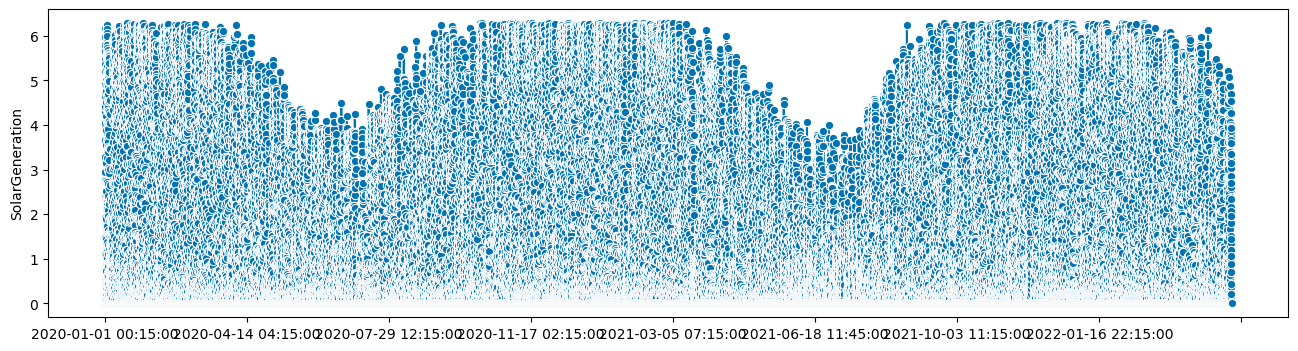

In [31]:
plot_series(df['SolarGeneration'])

In [32]:
y_train, y_test = temporal_train_test_split(df['SolarGeneration'], test_size=0.15)

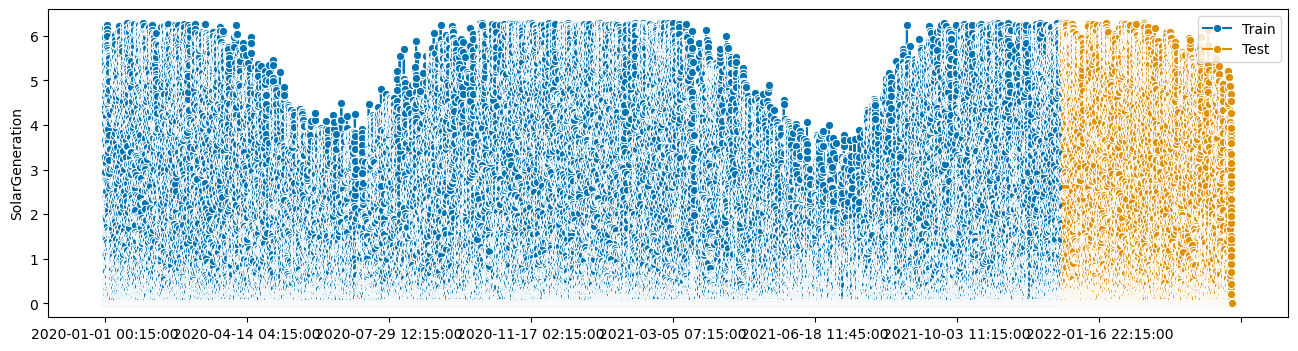

In [33]:
plot_series(y_train, y_test, labels = ['Train', 'Test']);

In [34]:
baseline = NaiveForecaster()
baseline.fit(y_train)
baseline_preds = baseline.predict(y_test.index)

C:\Users\jeffr\anaconda3\lib\site-packages\sktime\forecasting\base\_fh.py:802: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  freq = x.freq


ValueError: _coerce_to_period requires freq argument to be passed if x is pd.Timestamp

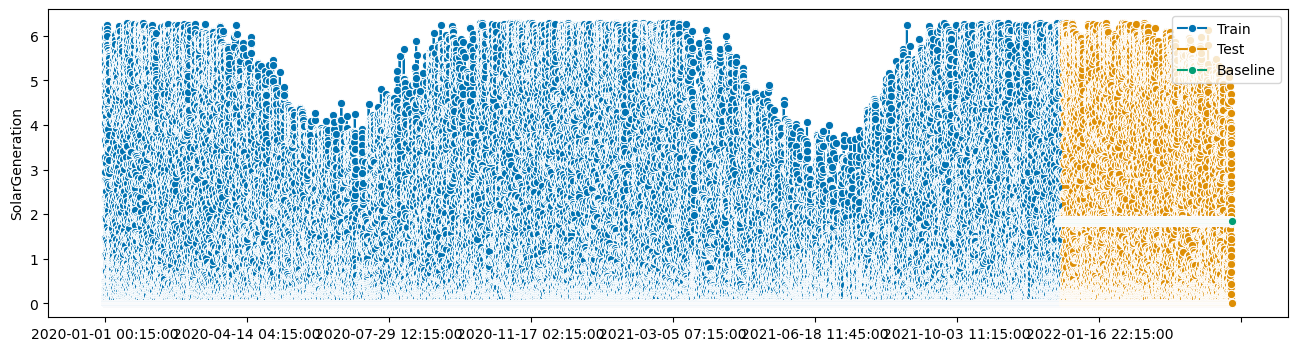

In [35]:
plot_series(y_train, y_test, baseline_preds, labels = ['Train', 'Test', 'Baseline']);

In [36]:
mean_squared_error(y_test, baseline_preds)

ValueError: Found input variables with inconsistent numbers of samples: [11898, 12154]

In [ ]:
sarima_model = AutoARIMA(sp=12, trace=True)
sarima_model.fit(y_train)